# I can do all this through him who give me strength

# Contents
1. Data Set Check
2. Preprocessing of Train/Test
 * 중점사항 : Age의 NaN값 채우기, 각 Feature의 카테고리 값 축소
3. Preprocessing of Session
 * 중점사항 : Action type 통합
4. Train Dataset과 Session Dataset 통합
5. Modeling
 * QDA / LDA
 * Navie Baye
 * Decision Tree
 * Random Forest
 * XG Boost


## 1. Data Set

In [5]:
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as pimg

In [8]:
%time
test = pd.read_csv("csv/test_users.csv")
%time
train = pd.read_csv("csv/train_users_2.csv")
%time
ss = pd.read_csv("csv/sample_submission_NDF.csv")

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [9]:
%time
age_gender = pd.read_csv("csv/age_gender_bkts.csv")
%time
countries = pd.read_csv("csv/countries.csv")
%time
sessions = pd.read_csv("csv/sessions.csv")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


### 1.1 Check Dataset

In [10]:
train.shape, test.shape

((213451, 16), (62096, 15))

In [11]:
# train / test columns 비교
set(train.columns) - set(test.columns)

{'country_destination'}

In [12]:
test["country_destination"] = np.nan
train.drop(columns="date_first_booking", axis=1, inplace=True)
test.drop(columns="date_first_booking", axis=1, inplace=True)

In [13]:
train.tail(3)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
213448,6o3arsjbb4,2014-06-30,20140630235754,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF
213450,nw9fwlyb5f,2014-06-30,20140630235824,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF


In [14]:
test.tail(3)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
62093,fa6260ziny,2014-09-30,20140930235408,-unknown-,NaN,basic,0,de,direct,direct,linked,Web,Windows Desktop,Firefox,NaN
62094,87k0fy4ugm,2014-09-30,20140930235430,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NaN
62095,9uqfg8txu3,2014-09-30,20140930235901,FEMALE,49.0,basic,0,en,other,other,tracked-other,Web,Windows Desktop,Chrome,NaN


In [15]:
# train / test columns 비교
set(train.columns) - set(test.columns)

set()

### 1.2 Train & Test Dataset 통합

In [16]:
airb = pd.concat([train, test])
airb.reset_index(inplace=True)

In [17]:
print("train set rows : {}".format(len(train)))
print("test  set rows : {}".format(len(test)))
print("airbnb  set rows : {}".format(len(airb)))

train set rows : 213451
test  set rows : 62096
airbnb  set rows : 275547


In [18]:
airb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 16 columns):
index                      275547 non-null int64
id                         275547 non-null object
date_account_created       275547 non-null object
timestamp_first_active     275547 non-null int64
gender                     275547 non-null object
age                        158681 non-null float64
signup_method              275547 non-null object
signup_flow                275547 non-null int64
language                   275547 non-null object
affiliate_channel          275547 non-null object
affiliate_provider         275547 non-null object
first_affiliate_tracked    269462 non-null object
signup_app                 275547 non-null object
first_device_type          275547 non-null object
first_browser              275547 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(3), object(12)
memory usage: 33.6+ MB


In [19]:
for col in airb.columns:
    print("{col} unique : {count}".format(col=col, count=len(airb[col].unique())))
    print("{col} null : {count}".format(col=col, count=airb[col].isnull().sum()))
    print()

index unique : 213451
index null : 0

id unique : 275547
id null : 0

date_account_created unique : 1726
date_account_created null : 0

timestamp_first_active unique : 275547
timestamp_first_active null : 0

gender unique : 4
gender null : 0

age unique : 146
age null : 116866

signup_method unique : 4
signup_method null : 0

signup_flow unique : 18
signup_flow null : 0

language unique : 26
language null : 0

affiliate_channel unique : 8
affiliate_channel null : 0

affiliate_provider unique : 18
affiliate_provider null : 0

first_affiliate_tracked unique : 8
first_affiliate_tracked null : 6085

signup_app unique : 4
signup_app null : 0

first_device_type unique : 9
first_device_type null : 0

first_browser unique : 55
first_browser null : 0

country_destination unique : 13
country_destination null : 62096



#### 1.2.1 Dataset 'ID' Check

In [20]:
print("{col} unique : {count}".format(col="id", count=len(airb.id.unique())))
print("{col} null : {count}".format(col="id", count=airb.id.isnull().sum()))

id unique : 275547
id null : 0


In [21]:
# ids are unique
airb.id.nunique() == airb.shape[0]

True

## 2. Prerocessing

### 2.1 Date_Account_Created (계정생성일)

#### 2.1.1 Datetime Parsing
* Year
* Month
* Day
* weekday

In [22]:
airb.date_account_created = pd.to_datetime(airb.date_account_created)

In [23]:
airb["dac_year"] = airb.date_account_created.dt.year
airb["dac_month"] = airb.date_account_created.dt.month
airb["dac_day"] = airb.date_account_created.dt.day
airb["dac_weekday"] = airb.date_account_created.dt.dayofweek

In [24]:
airb.filter(["id", "date_account_created", "dac_year", "dac_month", "dac_day", "dac_weekday"]).tail()

,id,date_account_created,dac_year,dac_month,dac_day,dac_weekday
275542,cv0na2lf5a,2014-09-30,2014,9,30,1
275543,zp8xfonng8,2014-09-30,2014,9,30,1
275544,fa6260ziny,2014-09-30,2014,9,30,1
275545,87k0fy4ugm,2014-09-30,2014,9,30,1
275546,9uqfg8txu3,2014-09-30,2014,9,30,1


#### 2.1.2 Visualization

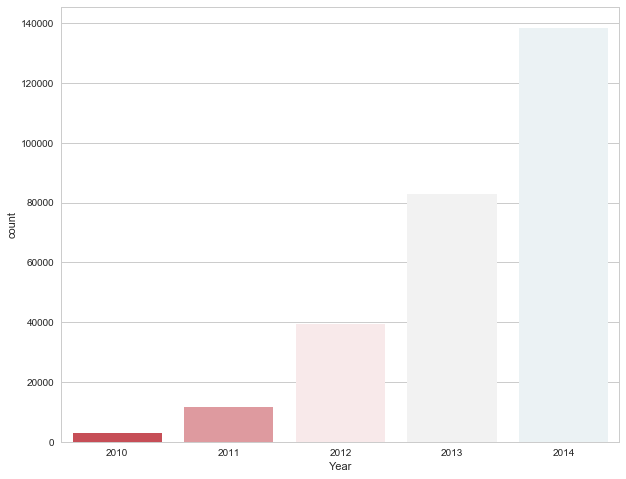

In [25]:
plt.figure(figsize=(10,8))
sns.countplot(x=airb.date_account_created.dt.year, palette=sns.diverging_palette(10, 220, sep=80, n=7))
plt.xlabel('Year')
plt.show()

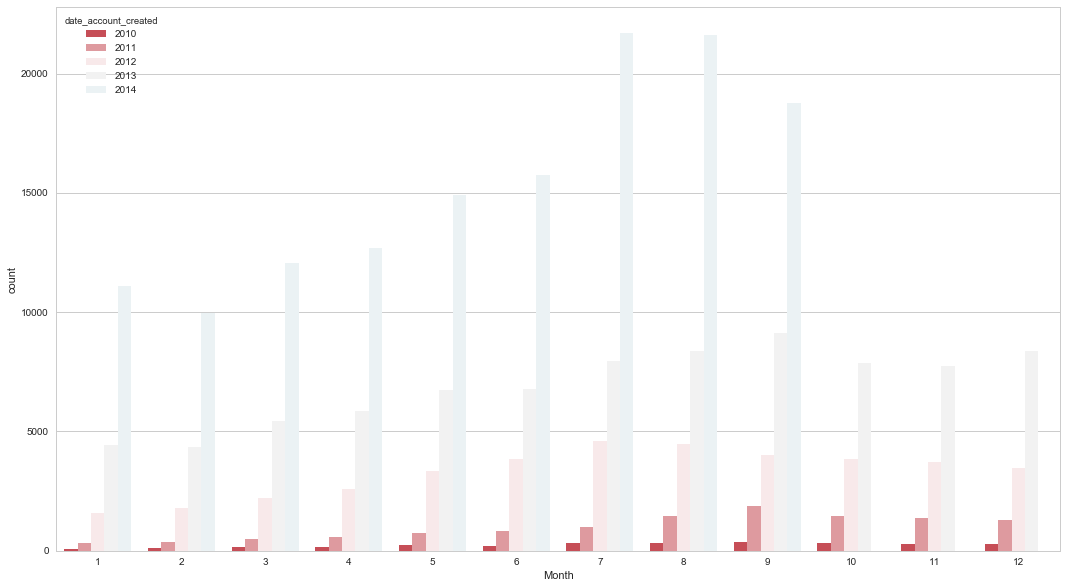

In [26]:
plt.figure(figsize=(18, 10))
sns.countplot(x=airb.date_account_created.dt.month, hue=airb.date_account_created.dt.year, palette=sns.diverging_palette(10, 220, sep=80, n=7))
plt.xlabel('Month')
plt.show()

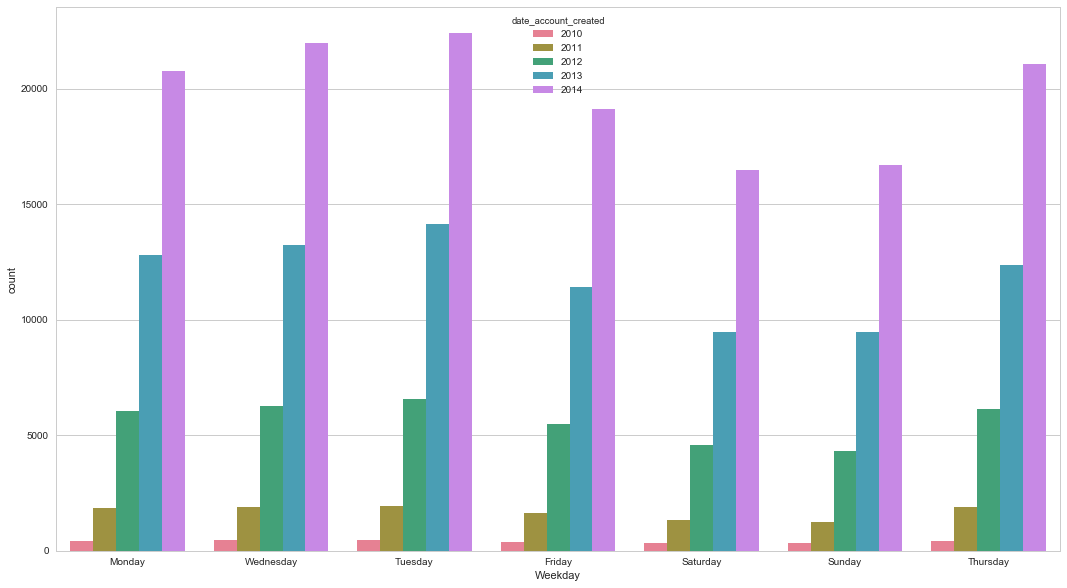

In [27]:
plt.figure(figsize=(18, 10))
sns.countplot(x=airb.date_account_created.dt.weekday_name, hue=airb.date_account_created.dt.year, palette="husl")
plt.xlabel('Weekday')
plt.show()

### 2.2 Timestamp_First_Active (첫 활동 시간)

#### 2.2.1 Datetime Parsing
* Year
* Month
* Day
* weekday
* hour

In [36]:
airb.timestamp_first_active = pd.to_datetime(airb.timestamp_first_active.astype(str))

In [37]:
airb["tfa_year"] = airb.timestamp_first_active.dt.year
airb["tfa_month"] = airb.timestamp_first_active.dt.month
airb["tfa_day"] = airb.timestamp_first_active.dt.day
airb["tfa_weekday"] = airb.timestamp_first_active.dt.dayofweek
airb["tfa_hour"] = airb.timestamp_first_active.dt.hour

In [38]:
airb.filter(["id", "timestamp_first_active", "tfa_year", "tfa_month", "tfa_day", "tfa_weekday", "tfa_hour"]).tail()

,id,timestamp_first_active,tfa_year,tfa_month,tfa_day,tfa_weekday,tfa_hour
275542,cv0na2lf5a,2014-09-30 23:52:32,2014,9,30,1,23
275543,zp8xfonng8,2014-09-30 23:53:06,2014,9,30,1,23
275544,fa6260ziny,2014-09-30 23:54:08,2014,9,30,1,23
275545,87k0fy4ugm,2014-09-30 23:54:30,2014,9,30,1,23
275546,9uqfg8txu3,2014-09-30 23:59:01,2014,9,30,1,23


#### 2.2.2 Visualization

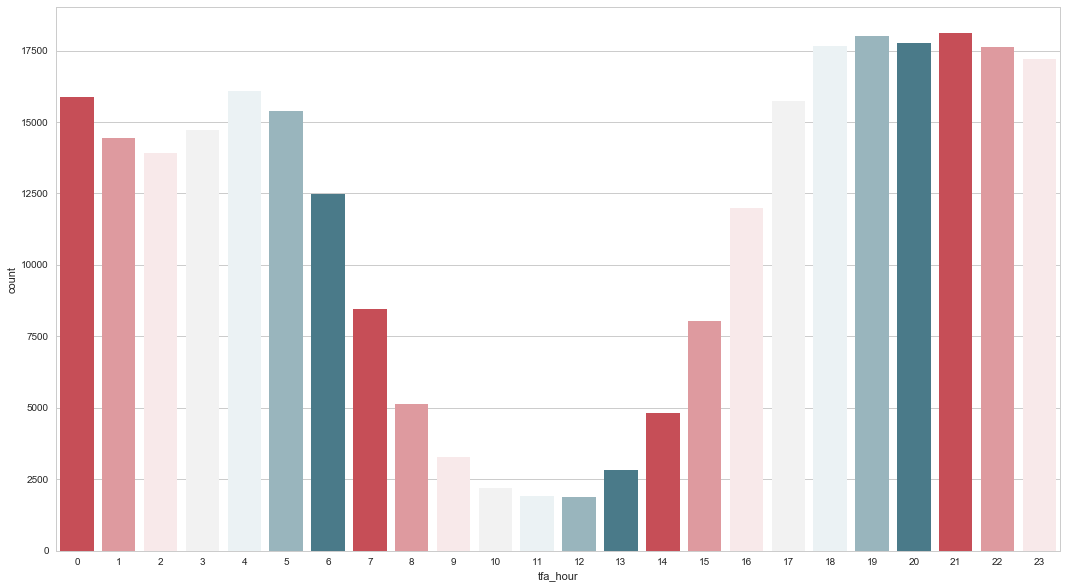

In [39]:
plt.figure(figsize=(18, 10))
sns.countplot(x=airb.tfa_hour, palette=sns.diverging_palette(10, 220, sep=80, n=7))
plt.show()

### 2.3 Gender

In [40]:
airb.gender.value_counts(normalize=True) * 100

-unknown-    46.990169
FEMALE       28.134583
MALE         24.754035
OTHER         0.121213
Name: gender, dtype: float64

#### 2.3.1 New Feature : 성별 정보 입력 여부

In [41]:
# f = (lambda gender : 0 if gender == "-unknown-" else 1)
airb["gender_known"] = airb.gender.apply(lambda gender : 0 if gender == "-unknown-" else 1)

In [42]:
airb.filter(["id", "gender", "gender_known"]).tail()

,id,gender,gender_known
275542,cv0na2lf5a,-unknown-,0
275543,zp8xfonng8,-unknown-,0
275544,fa6260ziny,-unknown-,0
275545,87k0fy4ugm,-unknown-,0
275546,9uqfg8txu3,FEMALE,1


In [43]:
airb.gender_known.value_counts(normalize=True) * 100

1    53.009831
0    46.990169
Name: gender_known, dtype: float64

### 2.4 Age

In [44]:
airb.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [45]:
airb.age.isnull().sum()

116866

#### 2.4.1 Odd Value 변환

In [46]:
airb.age[airb.age > 120]

388       2014.0
673       2014.0
1040      2014.0
1177      2013.0
1200      2014.0
1239      2014.0
1257      2014.0
1308      2014.0
1474      2014.0
1502      2014.0
1826      2014.0
1860      2014.0
2582      2014.0
3818      2014.0
4292      2013.0
5091      2014.0
5331      2014.0
5549      2014.0
5638      2014.0
5706      2014.0
5710      2014.0
5735      2014.0
5989      2014.0
6695      2014.0
6925      2014.0
7097      2014.0
7185      2013.0
7360      2014.0
7505      2014.0
7785      2014.0
           ...  
246075    1939.0
246329    1951.0
247333    1928.0
247630    1920.0
250588    2001.0
251243    1923.0
252888    1926.0
252920    1928.0
254405    1920.0
257383    1925.0
258053    1925.0
258832    1934.0
259037    1927.0
259068    1933.0
261098    2001.0
261212    1934.0
262753    1933.0
263026    1935.0
267006    1948.0
267268    2002.0
268764    1941.0
269071    1951.0
269408    2001.0
271110    1924.0
271419    1944.0
272027    1927.0
272279    1935.0
272637    1923

##### Age 값 중에 2010살 이상과 120살 이상은 잘못 입력된 값으로 가정

##### 1900살로 표시된 값들은 출생년도로 추정하여 2015년을 기준으로 나이를 계산 

In [47]:
print("{age} count : {count}".format(age=2014, count=len(airb.age[airb.age == 2014])))
print("{age} count : {count}".format(age=2013, count=len(airb.age[airb.age == 2013])))
print("{age} count : {count}".format(age=2012, count=len(airb.age[airb.age == 2012])))
print("{age} count : {count}".format(age=2011, count=len(airb.age[airb.age == 2011])))

2014 count : 710
2013 count : 39
2012 count : 0
2011 count : 0


In [48]:
print("{age} count : {count}".format(age="over 120", count=len(airb.age[(airb.age > 120) & (airb.age < 2010)])))

over 120 count : 81


In [49]:
# 사용자의 나이 최대값 120으로 가정 (기네스북 등재된 최고령자 : 117세)
airb.age[(airb.age > 120) & (airb.age < 2010)].value_counts()

1927.0    6
1928.0    6
2001.0    5
1931.0    4
1949.0    3
1934.0    3
1933.0    3
1925.0    3
1947.0    3
1924.0    3
1935.0    3
1932.0    3
1923.0    2
1936.0    2
1938.0    2
1926.0    2
1944.0    2
1940.0    2
1951.0    2
1920.0    2
1929.0    2
2000.0    1
1953.0    1
1939.0    1
1945.0    1
1937.0    1
1952.0    1
150.0     1
132.0     1
2008.0    1
1942.0    1
1930.0    1
1995.0    1
2002.0    1
1948.0    1
1922.0    1
1968.0    1
1954.0    1
1941.0    1
Name: age, dtype: int64

In [50]:
indices = list(airb.age[airb.age == 2014].index)
for index in indices:
    airb.loc[index, 'age'] = np.nan
    
indices = list(airb.age[airb.age == 2013].index)
for index in indices:
    airb.loc[index, 'age'] = np.nan
    
indices = list(airb.age[(airb.age > 120) & (airb.age < 1900)].index)
for index in indices:
    airb.loc[index, 'age'] = np.nan

indices = list(airb.age[(airb.age > 1900) & (airb.age < 2010)].index)
for index in indices:
        mod = 2015 - airb.age.loc[index]
        airb.loc[index, 'age'] = mod

In [54]:
# Check
print("{age} count : {count}".format(age=2014, count=len(airb.age[airb.age == 2014])))
print("{age} count : {count}".format(age=2013, count=len(airb.age[airb.age == 2013])))
print("{age} count : {count}".format(age=2012, count=len(airb.age[airb.age == 2012])))
print("{age} count : {count}".format(age=2011, count=len(airb.age[airb.age == 2011])))
print("{age} count : {count}".format(age="over 120", count=len(airb.age[(airb.age > 120) & (airb.age < 2010)])))

2014 count : 0
2013 count : 0
2012 count : 0
2011 count : 0
over 120 count : 0


In [53]:
print("{col} unique : {count}".format(col="age", count=len(airb.age.unique())))
print("{col} null : {count}".format(col="age", count=airb.age.isnull().sum()))

age unique : 108
age null : 117617


#### 2.4.2 Age Distribution

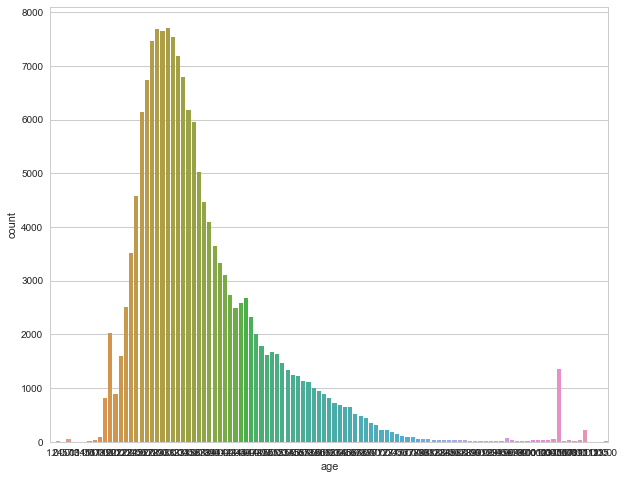

In [56]:
plt.figure(figsize=(10,8))

sns.countplot(x=airb.age.dropna())
plt.show()

In [57]:
airb.age.describe()

count    157930.000000
mean         36.881080
std          13.857854
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max         115.000000
Name: age, dtype: float64

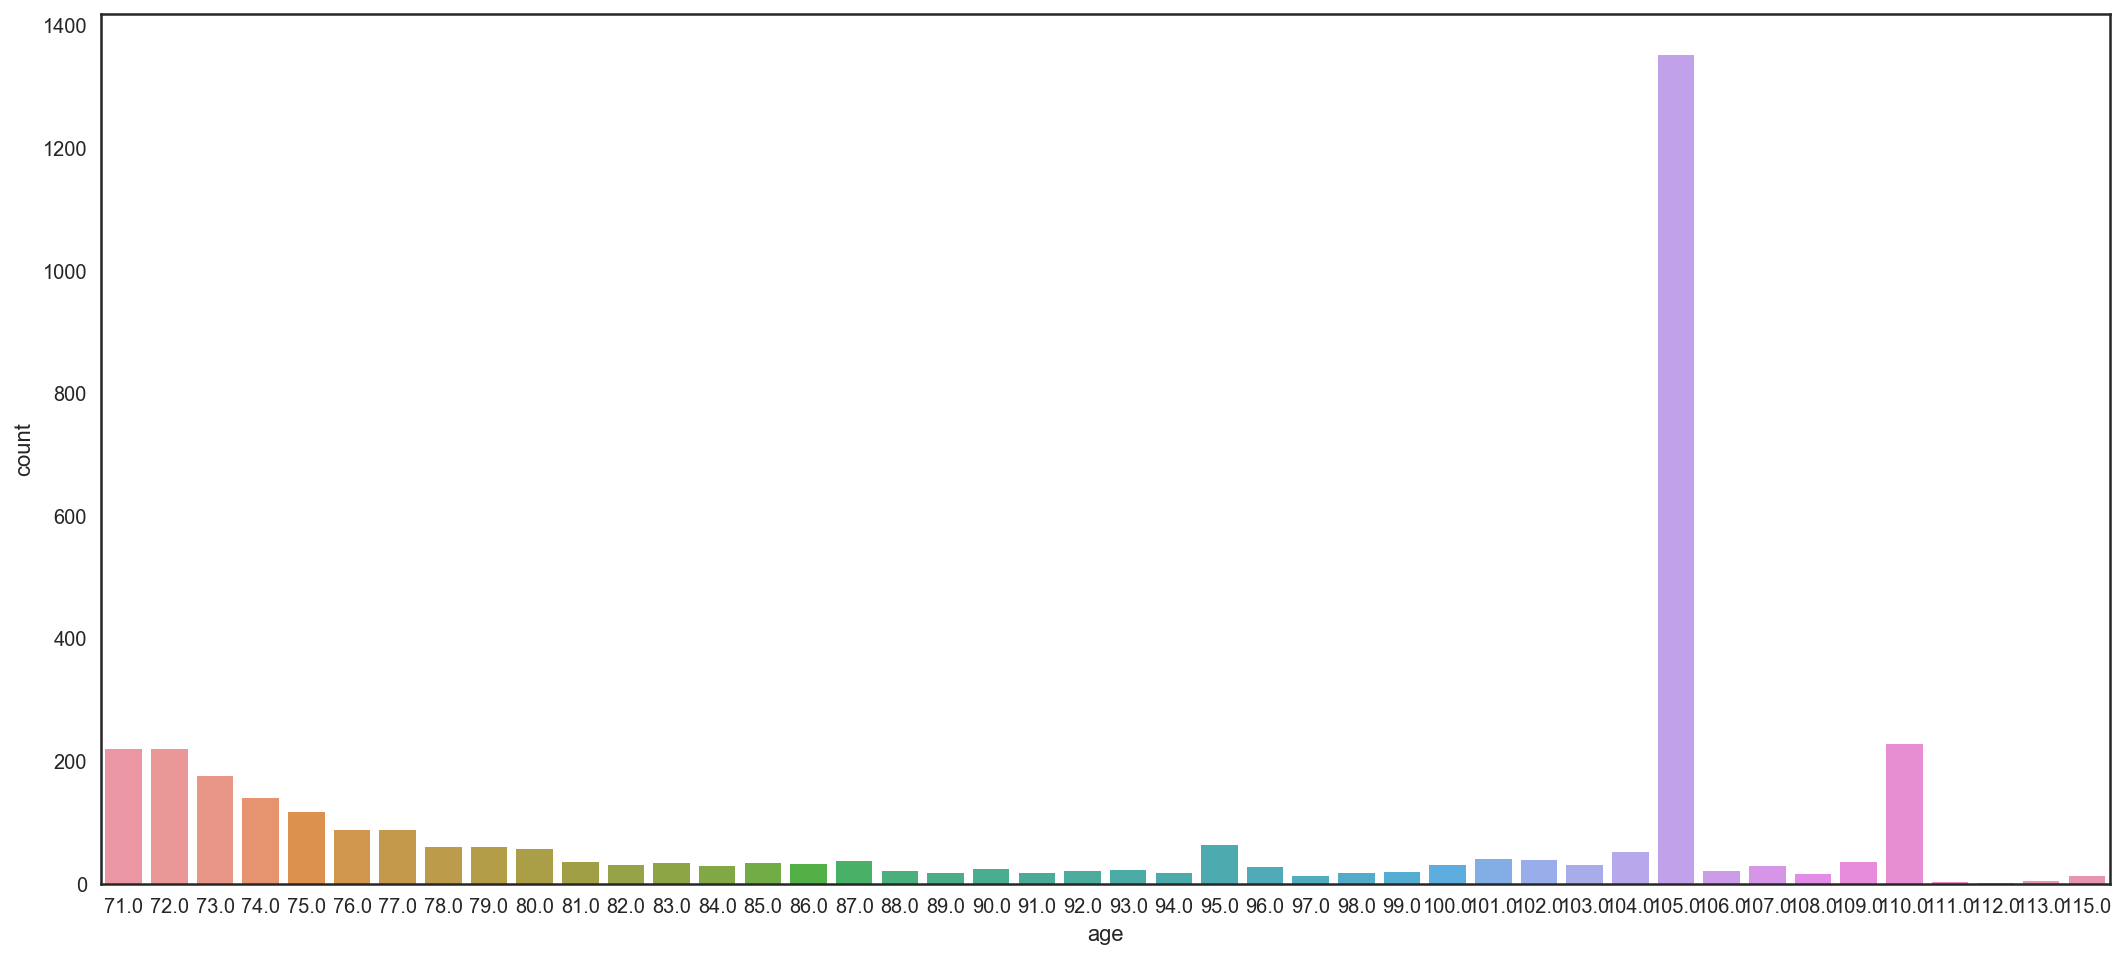

In [148]:
# Age 분포 오른쪽 확대

# plt.figure(figsize=(18,8))

# sns.countplot(x=airb.age[airb.age> 70])
# plt.show()

#### 2.4.3 Age Bucket : 나이를 5살씩 카테고리 분류

In [58]:
df = pd.DataFrame(columns = ["age", "age_bucket"])
df["age"] = list(range(0, 151))

age_bucket = list(age_gender.age_bucket.unique())
age_bucket.reverse()

for i in range(len(df)):
    if df.age[i] > 100:
        df.loc[i, "age_bucket"] = age_bucket[-1]
    else:
        df.loc[i, "age_bucket"] = age_bucket[i//5]

df = df.set_index("age")
df

,age_bucket
age,
0,0-4
1,0-4
2,0-4
3,0-4
4,0-4
5,5-9
6,5-9
7,5-9
8,5-9


In [59]:
airb["age_bkt"] = airb["age"].map(df.age_bucket)
airb.head()

,index,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,...,dac_month,dac_day,dac_weekday,tfa_year,tfa_month,tfa_day,tfa_weekday,tfa_hour,gender_known,age_bkt
0,0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,-unknown-,NaN,facebook,0,en,direct,...,6,28,0,2009,3,19,3,4,0,NaN
1,1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,38.0,facebook,0,en,seo,...,5,25,2,2009,5,23,5,17,1,35-39
2,2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.0,basic,3,en,direct,...,9,28,1,2009,6,9,1,23,1,55-59
3,3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,42.0,facebook,0,en,direct,...,12,5,0,2009,10,31,5,6,1,40-44
4,4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,-unknown-,41.0,basic,0,en,direct,...,9,14,1,2009,12,8,1,6,0,40-44


In [60]:
airb.age_bkt.value_counts(normalize=True) * 100

25-29    22.598620
30-34    22.421326
35-39    14.682454
40-44     9.007788
20-24     8.286583
45-49     6.583296
50-54     4.658393
55-59     3.430001
60-64     2.377002
15-19     1.885012
65-69     1.542456
100+      1.197366
70-74     0.670550
75-79     0.260242
80-84     0.116507
85-89     0.089280
95-99     0.088014
90-94     0.063319
5-9       0.029127
0-4       0.008865
10-14     0.003799
Name: age_bkt, dtype: float64

#### 2.4.4 Grouping : Age Bucket 중 비중이 낮은 그룹들을 다시 그룹화

In [52]:
indices = list(airb.age_bkt[(airb.age_bkt == '0-4') | (airb.age_bkt == '5-9') | 
                             (airb.age_bkt == '10-14') | (airb.age_bkt == '15-19')].index)

for index in indices:
    airb.loc[index, 'age_bkt'] = 'minor'

In [53]:
indices = list(airb.age[(airb.age_bkt == '70-74') | (airb.age_bkt == '75-79') |
                        (airb.age_bkt == '80-84')| (airb.age_bkt == '85-89')|
                        (airb.age_bkt == '90-94')| (airb.age_bkt == '95-99')| (airb.age_bkt == '100+')].index)
for index in indices:
    airb.loc[index, 'age_bkt'] = 'senior'

In [54]:
airb.age_bkt.value_counts(normalize=True) * 100

25-29     22.598620
30-34     22.421326
35-39     14.682454
40-44      9.007788
20-24      8.286583
45-49      6.583296
50-54      4.658393
55-59      3.430001
senior     2.485278
60-64      2.377002
minor      1.926803
65-69      1.542456
Name: age_bkt, dtype: float64

#### 2.4.4 Age_bucket NaN 값 처리

##### NaN Value to be filled based on distribution of existing values

In [61]:
dist = airb.age_bkt.value_counts(normalize=True) 
print(dist)

25-29    0.225986
30-34    0.224213
35-39    0.146825
40-44    0.090078
20-24    0.082866
45-49    0.065833
50-54    0.046584
55-59    0.034300
60-64    0.023770
15-19    0.018850
65-69    0.015425
100+     0.011974
70-74    0.006706
75-79    0.002602
80-84    0.001165
85-89    0.000893
95-99    0.000880
90-94    0.000633
5-9      0.000291
0-4      0.000089
10-14    0.000038
Name: age_bkt, dtype: float64


In [62]:
missing = airb['age_bkt'].isnull()
airb.loc[missing,'age_bkt'] = np.random.choice(dist.index, size=len(airb[missing]), p=dist.values)

In [63]:
airb[airb['age_bkt'].isnull()]

,index,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,...,dac_month,dac_day,dac_weekday,tfa_year,tfa_month,tfa_day,tfa_weekday,tfa_hour,gender_known,age_bkt


In [64]:
# check age_bkt distribution 
airb.age_bkt.value_counts(normalize=True) * 100

25-29    22.656752
30-34    22.392913
35-39    14.712916
40-44     9.018062
20-24     8.327073
45-49     6.556776
50-54     4.658008
55-59     3.429905
60-64     2.342613
15-19     1.840702
65-69     1.557629
100+      1.196892
70-74     0.647077
75-79     0.267831
80-84     0.116496
95-99     0.092180
85-89     0.086737
90-94     0.056615
5-9       0.028670
0-4       0.010162
10-14     0.003992
Name: age_bkt, dtype: float64

##### Distribution을 통해서 Age의 NaN값을 채운 이유

User의 행동을 기반으로 예측모델을 사용하여 Age Bucket을 분류/예측하려 하였으나,
    
약 50%의 데이터가 분포하고 있는 [25-29], [30-34] 구간의 recall score가 높게 나와

전반적인 예측 성능이 떨어짐

### 2.5.1 Signup Method (로그인 방법)

In [66]:
airb.signup_method.value_counts()

basic       198222
facebook     74864
google        2438
weibo           23
Name: signup_method, dtype: int64

### 2.5.2 Signup App

In [67]:
airb.signup_app.value_counts()

Web        219918
iOS         34593
Android     10519
Moweb       10517
Name: signup_app, dtype: int64

### 2.6.1 Affiliate Channel (제휴 마케팅)

In [68]:
airb.affiliate_channel.value_counts()

direct           181571
sem-brand         36439
sem-non-brand     20075
seo               14362
other              9547
api                8167
content            4118
remarketing        1268
Name: affiliate_channel, dtype: int64

### 2.6.2 Affiliate_Provider

In [69]:
airb.affiliate_provider.value_counts()

direct                 181270
google                  65956
other                   13036
facebook                 3996
bing                     3719
craigslist               3475
padmapper                 836
vast                      830
yahoo                     653
facebook-open-graph       566
gsp                       455
meetup                    358
email-marketing           270
naver                      66
baidu                      32
yandex                     18
wayn                        8
daum                        3
Name: affiliate_provider, dtype: int64

#### 2.6.3 Affiliate Provider Category 정리

In [68]:
list_afiliate = airb.affiliate_provider.value_counts()
df_afiliate = pd.DataFrame(list_afiliate)
afiliate_list = df_afiliate[df_afiliate['affiliate_provider']>500].index
afiliate_list
airb['affiliate_provider'] = airb['affiliate_provider'].apply(lambda x : x if x in afiliate_list else 'other')
airb.affiliate_provider.value_counts()

direct                 181270
google                  65956
other                   14246
facebook                 3996
bing                     3719
craigslist               3475
padmapper                 836
vast                      830
yahoo                     653
facebook-open-graph       566
Name: affiliate_provider, dtype: int64

In [69]:
# Facebook 통합
indices = list(airb.affiliate_provider[(airb.affiliate_provider == "facebook-open-graph")].index)
for index in indices:
    airb.loc[index, 'affiliate_provider'] = "facebook"
airb.affiliate_provider.value_counts()

direct        181270
google         65956
other          14246
facebook        4562
bing            3719
craigslist      3475
padmapper        836
vast             830
yahoo            653
Name: affiliate_provider, dtype: int64

In [70]:
indices = list(airb.affiliate_provider[(airb.affiliate_provider == "vast")| (airb.affiliate_provider == "padmapper")].index)
for index in indices:
    airb.loc[index, 'affiliate_provider'] = "other"
airb.affiliate_provider.value_counts()

direct        181270
google         65956
other          15912
facebook        4562
bing            3719
craigslist      3475
yahoo            653
Name: affiliate_provider, dtype: int64

### 2.7 First Device Type (첫 접속시 사용한 기기)

In [72]:
airb.first_device_type.value_counts()

Mac Desktop           106328
Windows Desktop        86948
iPhone                 39814
iPad                   18036
Other/Unknown          11167
Android Phone           9458
Android Tablet          2098
Desktop (Other)         1507
SmartPhone (Other)       191
Name: first_device_type, dtype: int64

#### 2.7.1 Others

In [73]:
indices = list(airb.first_device_type[(airb.first_device_type == "SmartPhone (Other)") | (airb.first_device_type == "Desktop (Other)")].index)
for index in indices:
    airb.loc[index, 'first_device_type'] = "Other/Unknown"
airb.first_device_type.value_counts()

Mac Desktop        106328
Windows Desktop     86948
iPhone              39814
iPad                18036
Other/Unknown       12865
Android Phone        9458
Android Tablet       2098
Name: first_device_type, dtype: int64

#### 2.7.2 OS별 통합 : 핸드폰과 태블릿은 OS별로 통합

In [75]:
indices = list(airb.first_device_type[(airb.first_device_type == "iPhone") | (airb.first_device_type == "iPad")].index)
for index in indices:
    airb.loc[index, 'first_device_type'] = "Mobile iOS"
airb.first_device_type.value_counts()

Mac Desktop        106328
Windows Desktop     86948
Mobile iOS          57850
Other/Unknown       12865
Android Phone        9458
Android Tablet       2098
Name: first_device_type, dtype: int64

In [76]:
indices = list(airb.first_device_type[(airb.first_device_type == "Android Phone") | (airb.first_device_type == "Android Tablet")].index)
for index in indices:
    airb.loc[index, 'first_device_type'] = "Mobile Android"
airb.first_device_type.value_counts()

Mac Desktop        106328
Windows Desktop     86948
Mobile iOS          57850
Other/Unknown       12865
Mobile Android      11556
Name: first_device_type, dtype: int64

In [77]:
# check : Okay
airb[airb.affiliate_provider == 'iPhone'].head()

,index,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,...,dac_month,dac_day,dac_weekday,tfa_year,tfa_month,tfa_day,tfa_weekday,tfa_hour,gender_known,age_bkt


### 2.8 First Browser (첫 접속시 이용한 브라우저)

In [78]:
airb.first_browser.value_counts()

Chrome                  78671
Safari                  53302
-unknown-               44394
Firefox                 38665
Mobile Safari           29636
IE                      24744
Chrome Mobile            3186
Android Browser          1577
AOL Explorer              254
Opera                     228
Silk                      172
IE Mobile                 118
BlackBerry Browser         89
Chromium                   83
Mobile Firefox             64
Maxthon                    60
Apple Mail                 45
Sogou Explorer             43
SiteKiosk                  27
RockMelt                   24
Iron                       24
IceWeasel                  14
Yandex.Browser             14
Pale Moon                  13
CometBird                  12
SeaMonkey                  12
Camino                      9
Opera Mini                  8
TenFourFox                  8
wOSBrowser                  7
CoolNovo                    6
Avant Browser               4
Opera Mobile                4
Mozilla   

In [79]:
list_browser = airb.first_browser.value_counts()
df_browser = pd.DataFrame(list_browser)
browser_list = df_browser[df_browser['first_browser']>100].index
airb['first_browser'] = airb['first_browser'].apply(lambda x : x if x in browser_list else 'other').replace('-unknown-', 'other')

In [80]:
airb.first_browser.value_counts()

Chrome             78671
Safari             53302
other              44994
Firefox            38665
Mobile Safari      29636
IE                 24744
Chrome Mobile       3186
Android Browser     1577
AOL Explorer         254
Opera                228
Silk                 172
IE Mobile            118
Name: first_browser, dtype: int64

In [81]:
indices = list(airb.first_browser[(airb.first_browser == "AOL Explorer") | (airb.first_browser == "Opera") | (airb.first_browser == "Silk")].index)
for index in indices:
    airb.loc[index, 'first_browser'] = "other"
airb.first_browser.value_counts()

Chrome             78671
Safari             53302
other              45648
Firefox            38665
Mobile Safari      29636
IE                 24744
Chrome Mobile       3186
Android Browser     1577
IE Mobile            118
Name: first_browser, dtype: int64

In [82]:
# Check : Okay
airb[airb.first_browser == 'Opera']

,index,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,...,dac_month,dac_day,dac_weekday,tfa_year,tfa_month,tfa_day,tfa_weekday,tfa_hour,gender_known,age_bkt


### 2.9 Language

In [83]:
airb.language.value_counts(normalize=True) * 100

en           96.367589
zh            0.955917
fr            0.547275
es            0.426062
ko            0.405013
de            0.354567
it            0.229725
ru            0.184361
ja            0.125206
pt            0.116858
sv            0.063873
nl            0.048631
tr            0.033388
da            0.027219
pl            0.027219
no            0.018509
cs            0.017783
el            0.010887
th            0.010162
hu            0.009073
id            0.008347
fi            0.007258
ca            0.002177
is            0.001815
hr            0.000726
-unknown-     0.000363
Name: language, dtype: float64

##### 언어는 96%가 영어를 사용

##### 그래서 카테고리를 영어와 비영어로 구분

In [84]:
# f = (lambda gender : 0 if gender == "-unknown-" else 1)
airb["language_en"] = airb.language.apply(lambda lang : 0 if lang != "en" else 1)

In [85]:
airb.filter(["id", "language", "language_en"]).tail()

,id,language,language_en
275542,cv0na2lf5a,en,1
275543,zp8xfonng8,ko,0
275544,fa6260ziny,de,0
275545,87k0fy4ugm,en,1
275546,9uqfg8txu3,en,1


In [86]:
airb.language_en.value_counts(normalize=True) * 100

1    96.367589
0     3.632411
Name: language_en, dtype: float64

#### 데이터 탐색 후 추가적인 전처리 (Pivot Table을 통해 몇개의 변수들로 그룹화 하였을때 작은 값들을 수정)

In [87]:
indices = list(train.first_device_type[(train.first_device_type == "Other/Unknown") & (train.first_browser == "Chrome Mobile")].index)
for index in indices:
    train.loc[index, 'first_device_type'] = "Mobile Android"

In [88]:
indices = list(train.first_device_type[(train.first_device_type == "Other/Unknown") & (train.first_browser == "Android Browser")].index)
for index in indices:
    train.loc[index, 'first_device_type'] = "Mobile Android"

In [89]:
indices = list(train.first_device_type[(train.first_device_type == "Mobile Android") & (train.first_browser == "Chrome")].index)
for index in indices:
    train.loc[index, 'first_device_type'] = "Chrome Mobile"

In [90]:
indices = list(train.first_device_type[(train.affiliate_channel == "remarketing") & (train.affiliate_provider == "other")].index)
for index in indices:
    train.loc[index, 'affiliate_provider'] = "google"

In [91]:
indices = list(train.first_device_type[(train.affiliate_channel == "sem-brand") & (train.affiliate_provider == "other")].index)
for index in indices:
    train.loc[index, 'affiliate_provider'] = "google"

In [92]:
indices = list(train.first_device_type[(train.affiliate_channel == "sem-non-brand") & (train.affiliate_provider == "facebook")].index)
for index in indices:
    train.loc[index, 'affiliate_channel'] = "seo"

### signup_flow

In [62]:
airb.signup_flow.value_counts()

0     206092
25     29834
12     11244
3       8822
2       6881
23      6408
24      4328
1       1047
8        315
6        301
21       197
5         36
20        14
16        11
15        10
14         4
10         2
4          1
Name: signup_flow, dtype: int64

In [63]:
list_signup_flow = airb.signup_flow.value_counts()
df_signup_flow = pd.DataFrame(list_signup_flow)
signup_flow_ls = df_signup_flow[df_signup_flow['signup_flow']>500].index
signup_flow_ls
airb['signup_flow'] = airb['signup_flow'].apply(lambda x : x if x in signup_flow_ls else 'other')
airb.signup_flow.value_counts()

0        206092
25        29834
12        11244
3          8822
2          6881
23         6408
24         4328
1          1047
other       891
Name: signup_flow, dtype: int64

## 3. Prerocessing of Sessions

In [4]:
df_sessions = sessions.copy()

In [5]:
df_sessions.action.isnull().sum()

79626

In [6]:
print('Working on Session data...')
#Filling nan with specific value ('NAN')
df_sessions.action = df_sessions.action.fillna('NAN')
df_sessions.action_type = df_sessions.action_type.fillna('NAN')
df_sessions.action_detail = df_sessions.action_detail.fillna('NAN')
df_sessions.device_type = df_sessions.device_type.fillna('NAN')

Working on Session data...


In [ ]:
#Action values with low frequency are changed to 'OTHER'
act_freq = 100  #Threshold for frequency
act = dict(zip(*np.unique(df_sessions.action, return_counts=True)))
df_sessions.action = df_sessions.action.apply(lambda x: 'OTHER' if act[x] < act_freq else x)

In [ ]:
df_sessions.action.value_counts().sum()

In [ ]:
f_act = df_sessions.action.value_counts().argsort() # 231개 
f_act_detail = df_sessions.action_detail.value_counts().argsort() # 156
f_act_type = df_sessions.action_type.value_counts().argsort() # 11
f_dev_type = df_sessions.device_type.value_counts().argsort() # 14

In [ ]:
dgr_sess = df_sessions.groupby(['user_id'])

In [ ]:
#Loop on dgr_sess to create all the features.
samples = []
cont = 0
ln = len(dgr_sess)

for g in dgr_sess:
    if cont%10000 == 0:
        print("%s from %s" %(cont, ln))
    # 아이디 당 세션 정보
    gr = g[1]
    l = []
    
    # 해당 id 
    l.append(g[0])
    
    # 해당 id의 세션 row 개수 (= 해당 id 의 action 개수) 
    l.append(len(gr))
    
    sev = gr.secs_elapsed.fillna(0).values   #These values are used later.
    
    #action features
    #(how many times each value occurs, numb of unique values, mean and std) / id
    c_act = [0] * len(f_act)    # action 개수 만큼 0벡터 생성
    for i,v in enumerate(gr.action.values):  
        # one hot vector
        # i: value count, v: name of action
        # f_act = action unique, count 
        # one hot vector: c_act 해당 클래스 부분에 1로 표시 
        c_act[f_act[v]] += 1
    # c_act_uqc: 해당 id 의 unique한 action => count, count의 평균, 표준편차
    _, c_act_uqc = np.unique(gr.action.values, return_counts=True)
    c_act += [len(c_act_uqc), np.mean(c_act_uqc), np.std(c_act_uqc)]
    l = l + c_act

    
    #action_detail features
    #(how many times each value occurs, numb of unique values, mean and std)
    c_act_detail = [0] * len(f_act_detail)
    for i,v in enumerate(gr.action_detail.values):
        c_act_detail[f_act_detail[v]] += 1 
        
    _, c_act_det_uqc = np.unique(gr.action_detail.values, return_counts=True)
    c_act_detail += [len(c_act_det_uqc), np.mean(c_act_det_uqc), np.std(c_act_det_uqc)]
    l = l + c_act_detail
    
    
    #action_type features
    #(how many times each value occurs, numb of unique values, mean and std
    #+ log of the sum of secs_elapsed for each value)
    l_act_type = [0] * len(f_act_type)
    c_act_type = [0] * len(f_act_type)
    for i,v in enumerate(gr.action_type.values):
        l_act_type[f_act_type[v]] += sev[i] # 해당 action type 실행 sec. 해당 action type 클래스에 값 넣어주기  
        c_act_type[f_act_type[v]] += 1  
        
    l_act_type = np.log(1 + np.array(l_act_type)).tolist()
    _, c_act_type_uqc = np.unique(gr.action_type.values, return_counts=True)
    c_act_type += [len(c_act_type_uqc), np.mean(c_act_type_uqc), np.std(c_act_type_uqc)]
    l = l + c_act_type + l_act_type    
    
    
    #device_type features
    #(how many times each value occurs, numb of unique values, mean and std)
    c_dev_type  = [0] * len(f_dev_type)
    for i,v in enumerate(gr.device_type .values):
        c_dev_type[f_dev_type[v]] += 1 
    c_dev_type.append(len(np.unique(gr.device_type.values)))
    _, c_dev_type_uqc = np.unique(gr.device_type.values, return_counts=True)
    c_dev_type += [len(c_dev_type_uqc), np.mean(c_dev_type_uqc), np.std(c_dev_type_uqc)]        
    l = l + c_dev_type   
    

    #secs_elapsed features        
    l_secs = [0] * 5 
    l_log = [0] * 15
    if len(sev) > 0:
        #Simple statistics about the secs_elapsed values.
        l_secs[0] = np.log(1 + np.sum(sev))
        l_secs[1] = np.log(1 + np.mean(sev)) 
        l_secs[2] = np.log(1 + np.std(sev))
        l_secs[3] = np.log(1 + np.median(sev))
        l_secs[4] = l_secs[0] / float(l[1])

        # ---------------------------------------------------------------- #
        #Values are grouped in 15 intervals. Compute the number of values
        #in each interval.
        log_sev = np.log(1 + sev).astype(int)
        l_log = np.bincount(log_sev, minlength=15).tolist()                      
    l = l + l_secs + l_log
    
    #The list l has the feature values of one sample.
    samples.append(l)
    cont += 1
#     print(l)
#     break

# 결과적으로 for 문을 통해서 아이디 당 sessions.csv 의 action, action_type(count, log), action_detail, device_type, 
# secs_elapsed(log - sum, mean, std, median, l_secs[0] / float(l[1])) 더미 변수로 변경

In [ ]:
#Creating a dataframe with the computed features    
col_names = []    #name of the columns
for i in range(len(samples[0])-1):
    col_names.append('c_' + str(i)) 
col_names    

In [ ]:
#preparing objects    
samples = np.array(samples)
samp_ar = samples[:, 1:].astype(np.float16)
samp_id = samples[:, 0]   #The first element in obs is the id of the sample.

In [ ]:
#creating the dataframe        
df_agg_sess = pd.DataFrame(samp_ar, columns=col_names)
df_agg_sess['id'] = samp_id
df_agg_sess.index = df_agg_sess.id

In [ ]:
df_agg_sess

sessions
* device_type - 클래스 수 줄이기 
     - train 디바이스와 비슷하게 줄이기
     - 

## 4. Modeling

In [ ]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
import operator

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score

### 4.1 Splitting train and test

### 4.2 Feature Selection

In [ ]:
# Feature 선택
feature_names = ['signup_method', 'signup_app', 'affiliate_channel',
                 'affiliate_provider', 'first_device_type', 'first_browser','country_destination']
dfX0 = age_train[feature_names].copy()
dfy0 = age_train['age_bkt'].copy()

In [ ]:
# Dummy 변환
dummies = feature_names
for feature in dummies:
    dummy_features = pd.get_dummies(dfX[feature], prefix=feature)
    for dummy in dummy_features:
        dfX[dummy] = dummy_features[dummy]
    dfX = dfX.drop([feature], 1)

In [ ]:
# Check dummy transform
dfX.head()

In [ ]:
# 종속변수 Label Encoder
dfy = pd.DataFrame(LabelEncoder().fit_transform(dfy), index=dfy.index)
dfy.T

### Decision Tree

In [ ]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_leaf=1).fit(dfX, dfy2)

In [ ]:
print(classification_report(dfy, model.predict(dfX)))

In [ ]:
# Tree 그리기
command_buf = io.StringIO() 
export_graphviz(model, out_file=command_buf) 
graph = pydot.graph_from_dot_data(command_buf.getvalue())[0] 
image = graph.create_png()
#Image(image)
# newImg1 = pimg.new('RGB', (512,512))
# newImg1.pimg.save("img1.png")

### Naive Bayes

In [ ]:
model_mult = MultinomialNB().fit(dfX, dfy)

In [ ]:
print(classification_report(dfy, model_mult.predict(dfX)))

### Random Forest

In [ ]:
n_estimators = 100 # 생성될 트리 갯수
model_rf = RandomForestClassifier(max_depth=100, n_estimators=n_estimators).fit(dfX, dfy)

In [ ]:
print(classification_report(dfy, model_rf.predict(dfX)))

In [ ]:
# 중요 Feature
importances = model_rf.feature_importances_

std = np.std([model_rf.feature_importances_ for tree in model_rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(dfX.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

### XG Boost

In [ ]:
labels = airb['country_destination'].values
n_labels = len(set(labels))
n_test = dfX.shape[0]

In [ ]:
params = {
    'objective': 'multi:softprob',
    'eval_metric': 'merror',
    'num_class': n_labels,
    'eta': 0.3,
    'max_depth': 6,
    'subsample': 0.5,
    'colsample_bytree': 0.3,
    'silent': 1,
    'seed': 123
}

num_boost_round = 50

dtrain = xgb.DMatrix(dfX, dfy2)
res = xgb.cv(params, dtrain, num_boost_round=num_boost_round, nfold=5,
             callbacks=[xgb.callback.print_evaluation(show_stdv=True),
                        xgb.callback.early_stop(1)])

In [ ]:
clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round)

In [ ]:
importance = clf.get_fscore()
importance_df = pd.DataFrame(
    sorted(importance.items(), key=operator.itemgetter(1)),
    columns=['feature', 'fscore']
)
importance_df = importance_df.iloc[-20:, :]

In [ ]:
plt.figure()
importance_df.plot(kind='barh', x='feature', y='fscore',
                   legend=False, figsize=(30, 12))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance.png')

In [ ]:
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('airbin-sub1.csv',index=False)